## LA FILTRACIÓN
El 25 de febrero de 2022, la familia de ransomware Conti prometió apoyo en la invasión rusa de Ucrania. Como respuesta, el 27 de febrero de 2022, un supuesto ucraniano, filtró las conversaciones internas de los miembros de Conti a través de una cuenta de Twitter llamada **ContiLeaks**. Las conversaciones incluyeron:

- Registros de Jabber publicados en varias partes por el perfil original de ContiLeaks en Twitter del servidor Conti Jabber alojado en 3mcco35auwcstmt[.]onion.
- Servidores de Rocket.Chat diferentes

## Corpus Conti `build_conti_corpus.py` (Conti Rocket.Chat)

En este primer examen ya se aprecia que está en **Ruso**... esto lo hace verdaderamente interesante para la aproximación de análisis del discurso. El siguiente paso es crear el corpus de los chats de Rocket. Para ello hay que conocer la estructura de RocketCahat. El corpus lo quiero construir en torno al actor, agruparé mensajes por actor y hay que revisar las rooms generales, de forma que cuando A habla en una de ellas no guarde en el corpus ese mismo mensaje de A por cada uno de los miembros de la room (crearía duplicidades contaminando).

**Data Preparation** del pipeline, transforma los dumps de Rocket.Chat en un conjunto de datos **actor-céntrico** de cara a crear luego embeddings (SBERT/BERT) y análisis de proximidad discursiva entre actores.


1. **Ingesta**: recorre la carpeta de entrada con subdirectorios (rooms/instancias) y localiza los ficheros JSON con mensajes.
2. **Normalización**: extrae de cada mensaje los campos relevantes (actor/usuario, room, texto), aplicando limpieza básica
   (p.ej., ignorar vacíos). NO ES AGRESIVA, PERDERÍA PARTE DE LAS CARACTERÍSTICAS DEL DISCURSO!!
3. **Agregación por actor**: construye un corpus actor asociado a su texto (concatenado o en unidades).
4. **Artefactos para EDA/visualización**: tablas de conteo:
   - volumen de mensajes por actor (para “Top N” usuarios más activos),
   - volumen por room y usuarios inferidos por room (para explorar estructura de canales).
5. **Salida**: escribe en el repo (`ransomtales/data/processed` y `ransomtales/results/tables`)



In [2]:
from pathlib import Path
import json

path = Path.home() / "Documentos" / "dark" / "conti-leaks-englished" / "rocket-chat" / "original" / "6yp2jljwgdxmwy4uxfaxbkjgm2txlxxb5akxn43cyaz3cjo2gqd65yid.onion" / "2021-10-25-general.json"

# Leo un chunk inicial
raw = path.read_text(encoding="utf-8", errors="replace")
chunk = raw[:20000]  # primeros 20 KB

print(f"Archivo: {path}")
print(f"Tamaño (bytes): {path.stat().st_size}")

# JSON completo si razonable...
try:
    obj = json.loads(raw)  
    if isinstance(obj, list):
        print(f"JSON type: list | length: {len(obj)}")
        print("\nPrimer elemento:\n")
        print(json.dumps(obj[0], indent=2, ensure_ascii=False)[:4000])
    elif isinstance(obj, dict):
        print("JSON type: dict | keys:", list(obj.keys())[:25])
        print("\nVista parcial:\n")
        print(json.dumps(obj, indent=2, ensure_ascii=False)[:4000])
    else:
        print("JSON type:", type(obj))
except Exception as e:
    print("No se pudo parsear como JSON completo")
    print("Error:", repr(e))
    print("\nPrimeras 60 líneas en crudo:\n")
    lines = raw.splitlines()
    for i, line in enumerate(lines[:60], start=1):
        print(f"{i:02d}: {line[:200]}")


Archivo: /home/drjekyll/Documentos/dark/conti-leaks-englished/rocket-chat/original/6yp2jljwgdxmwy4uxfaxbkjgm2txlxxb5akxn43cyaz3cjo2gqd65yid.onion/2021-10-25-general.json
Tamaño (bytes): 14890
JSON type: dict | keys: ['messages', 'success']

Vista parcial (pretty):

{
  "messages": [
    {
      "_id": "M3kBd3BEG4GaxeLTw",
      "rid": "GENERAL",
      "msg": "@dildoso +",
      "ts": "2021-10-25T19:14:35.801Z",
      "u": {
        "_id": "wDmyidv6t47pN9AXi",
        "username": "gall",
        "name": "gall"
      },
      "urls": [],
      "mentions": [
        {
          "_id": "PD6uG8WCBg8pmvZq5",
          "username": "dildoso",
          "name": "dildoso",
          "type": "user"
        }
      ],
      "channels": [],
      "md": [
        {
          "type": "PARAGRAPH",
          "value": [
            {
              "type": "MENTION_USER",
              "value": {
                "type": "PLAIN_TEXT",
                "value": "dildoso"
              }
            },
     

In [14]:
import sys
from pathlib import Path

repo_root = Path.home() / "Documentos" / "dark" / "dark-speech"
sys.path.insert(0, str(repo_root))

from ransomtales.src.ingest.build_conti_corpus_v4 import build_conti_corpus

input_path = Path.home() / "Documentos" / "dark" / "conti-leaks-englished" / "rocket-chat" / "original"
artifacts = build_conti_corpus(input_path=input_path, repo_root=repo_root)
artifacts

print("Aúpa!")


[INFO] Build complete
[INFO] Files processed (with content): 1548
[INFO] Messages ingested: 83325
[INFO] Actors found: 247
[INFO] Rooms inferred: 1548
[INFO] Corpus: /home/drjekyll/Documentos/dark/dark-speech/ransomtales/data/processed/conti_actor_corpus.jsonl
[INFO] Top10:  /home/drjekyll/Documentos/dark/dark-speech/ransomtales/results/tables/top10_actors_by_msgs.csv
[INFO] Rooms:  /home/drjekyll/Documentos/dark/dark-speech/ransomtales/results/tables/rooms_users.csv
Aúpa!


Vamos a echar un ojo antes de nada... Primero con tabla y luego podemos pintarlo con circulos

In [15]:
import pandas as pd
from pathlib import Path

csv_path = (
    Path.home()
    / "Documentos"
    / "dark"
    / "dark-speech"
    / "ransomtales"
    / "results"
    / "tables"
    / "top10_actors_by_msgs.csv"
)

df_top = pd.read_csv(csv_path)

# las primeras 15 filas 
df_top.head(15)


,actor,n_messages
0,tl1,27544
1,user8,10466
2,tl2,5715
3,user9,5094
4,user4,4563
5,user7,3634
6,user3,3189
7,angelo,2894
8,kermit,1386
9,homer,1298


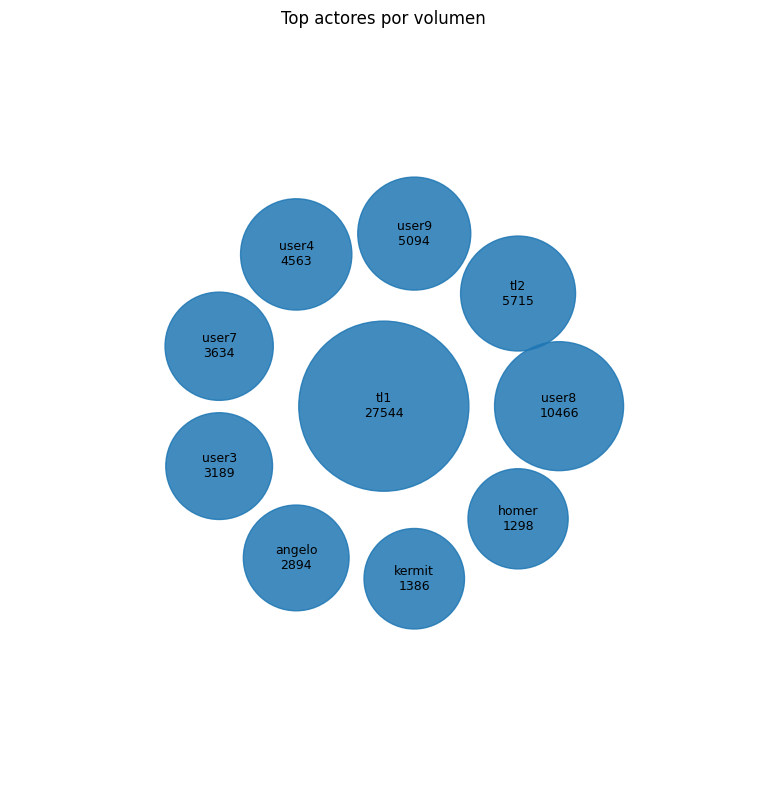

<Figure size 640x480 with 0 Axes>

,actor,n_messages
0,tl1,27544
1,user8,10466
2,tl2,5715
3,user9,5094
4,user4,4563
5,user7,3634
6,user3,3189
7,angelo,2894
8,kermit,1386
9,homer,1298


In [29]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

candidates = [
    Path("ransomtales/results/tables/top10_actors_by_msgs.csv"),
    Path("ransomtales/results/tables/top_actors_by_msgs.csv"),
    Path.home() / "Documentos" / "dark" / "dark-speech" / "ransomtales" / "results" / "tables" / "top10_actors_by_msgs.csv",
    Path.home() / "Documentos" / "dark" / "dark-speech" / "ransomtales" / "results" / "tables" / "top_actors_by_msgs.csv",
]
csv_path = next((p for p in candidates if p.exists()), None)
if csv_path is None:
    raise FileNotFoundError("No encuentro el CSV en las rutas candidatas.")

df = pd.read_csv(csv_path)
df = df.sort_values("n_messages", ascending=False).head(15).reset_index(drop=True)


vals = df["n_messages"].astype(float).to_numpy()
min_area, max_area = 5200, 15000 # tamaños
if vals.max() == vals.min():
    areas = np.full_like(vals, (min_area + max_area) / 2.0)
else:
    areas = min_area + (vals - vals.min()) * (max_area - min_area) / (vals.max() - vals.min())

# radial compacto
n = len(df)
coords = np.zeros((n, 2), dtype=float)

if n > 1:
    R = 0.75 # modifica separación
    k = n - 1
    angles = np.linspace(0, 2*np.pi, k, endpoint=False)

    coords[0] = (0.0, 0.0)  # actor más activo en el centro
    coords[1:, 0] = R * np.cos(angles)
    coords[1:, 1] = R * np.sin(angles)

# plot
plt.figure(figsize=(8, 8))
plt.scatter(coords[:, 0], coords[:, 1], s=areas, alpha=0.85)

for (x, y), actor, count in zip(coords, df["actor"], df["n_messages"]):
    plt.text(
        x, y,
        f"{actor}\n{int(count)}",
        ha="center", va="center",
        fontsize=9
    )

plt.title("Top actores por volumen")
plt.axis("off")
plt.gca().set_aspect("equal", adjustable="box")

# forzar límites para evitar separación artificial
pad = 1.6
plt.xlim(-pad, pad)
plt.ylim(-pad, pad)
plt.tight_layout()
plt.show()
plt.tight_layout()
plt.show()

df


## Jabber

Ahora hay que añadir los Jabber, para eso haré dos corpus más, uno solo de jabber y otro ambos juntos.

Tras unos dolores de cabeza v1 v2 v3... Nos damos cuenta de que los logs Jabber no están en ningún formato de exportación estándar. Son objetos **JSON concatenados**, multi-línea...


In [51]:
from pathlib import Path
import pandas as pd

csv_path = (
    Path.home()
    / "Documentos"
    / "dark"
    / "dark-speech"
    / "ransomtales"
    / "results"
    / "tables"
    / "jabber_top15_actors_by_msgs.csv"
)

df_jabber_top = pd.read_csv(csv_path)

df_jabber_top


,actor,n_messages
0,target@q3mcco35auwcstmt.onion,26770
1,bentley@q3mcco35auwcstmt.onion,17440
2,stern@q3mcco35auwcstmt.onion,11947
3,defender@q3mcco35auwcstmt.onion,9666
4,hof@q3mcco35auwcstmt.onion,5041
5,mango@q3mcco35auwcstmt.onion,4118
6,driver@q3mcco35auwcstmt.onion,4038
7,deploy@q3mcco35auwcstmt.onion,3780
8,mushroom@q3mcco35auwcstmt.onion,3690
9,bio@q3mcco35auwcstmt.onion,3196


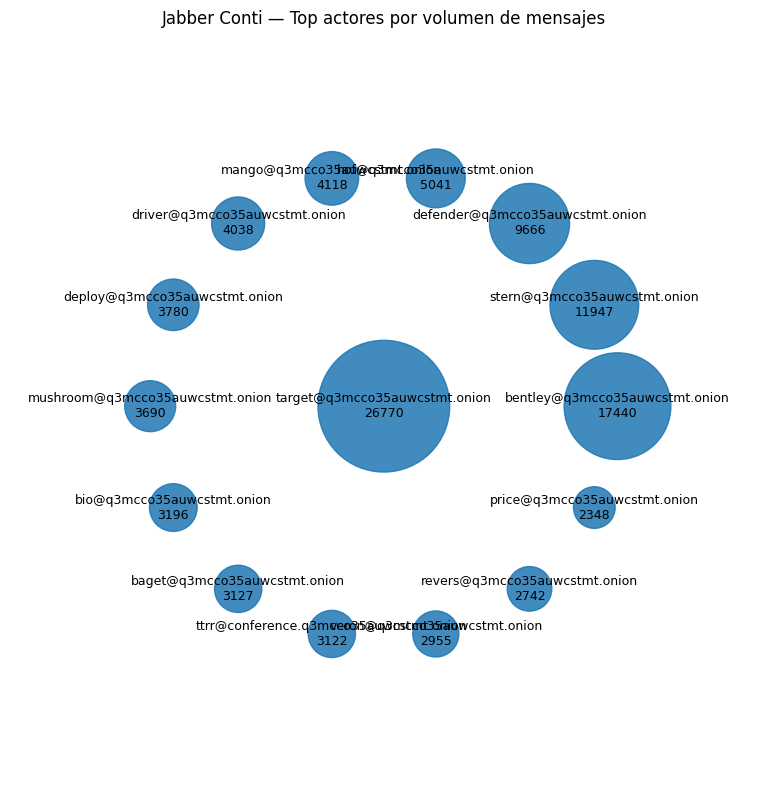

In [52]:
import matplotlib.pyplot as plt
import numpy as np

df = df_jabber_top.sort_values("n_messages", ascending=False).reset_index(drop=True)

# Escalado de áreas
vals = df["n_messages"].astype(float).to_numpy()
min_area, max_area = 900, 9000

if vals.max() == vals.min():
    areas = np.full_like(vals, (min_area + max_area) / 2)
else:
    areas = min_area + (vals - vals.min()) * (max_area - min_area) / (vals.max() - vals.min())

# Layout radial
n = len(df)
coords = np.zeros((n, 2))

if n > 1:
    R = 1.0
    angles = np.linspace(0, 2 * np.pi, n - 1, endpoint=False)
    coords[0] = (0, 0)
    coords[1:, 0] = R * np.cos(angles)
    coords[1:, 1] = R * np.sin(angles)

# Plot
plt.figure(figsize=(8, 8))
plt.scatter(coords[:, 0], coords[:, 1], s=areas, alpha=0.85)

for (x, y), actor, count in zip(coords, df["actor"], df["n_messages"]):
    plt.text(x, y, f"{actor}\n{int(count)}", ha="center", va="center", fontsize=9)

plt.title("Jabber Conti — Top actores por volumen de mensajes")
plt.axis("off")
plt.gca().set_aspect("equal")
plt.xlim(-1.6, 1.6)
plt.ylim(-1.6, 1.6)
plt.tight_layout()
plt.show()


## Secretos temporales...
Anlizar los tiempos de las conversaciones, para contextualizar. En el corpus no se ha guardado el t ni hace falta, vuelvo al bruto

In [61]:
from pathlib import Path
import json
import pandas as pd

input_root = (
    Path.home()
    / "Documentos"
    / "dark"
    / "conti-leaks-englished"
    / "rocket-chat"
    / "original"
)

records = []

for room_dir in input_root.iterdir():
    if not room_dir.is_dir():
        continue

    for json_file in room_dir.glob("*.json"):
        # Ignorar metadata
        if json_file.name in {"rooms.json", "users.list"}:
            continue

        try:
            with json_file.open("r", encoding="utf-8", errors="replace") as f:
                payload = json.load(f)
        except Exception:
            continue

        messages = payload.get("messages")
        if not isinstance(messages, list):
            continue

        for msg in messages:
            ts = msg.get("ts")
            if isinstance(ts, str):
                try:
                    date = pd.to_datetime(ts, utc=True).date()
                    records.append({"date": date})
                except Exception:
                    pass

df_dates = pd.DataFrame(records)

df_dates.head(), len(df_dates)


(         date
 0  2022-02-17
 1  2022-02-17
 2  2022-02-17
 3  2022-02-17
 4  2022-02-17,
 88116)

In [62]:
# agregar por día
activity_by_day = (
    df_dates
    .groupby("date")
    .size()
    .reset_index(name="n_messages")
    .sort_values("date")
)

activity_by_day.head(10), activity_by_day.tail(10)


(         date  n_messages
 0  2020-08-31          38
 1  2020-09-01         201
 2  2020-09-02          12
 3  2020-09-03          52
 4  2020-09-04         107
 5  2020-09-05           3
 6  2020-09-07         136
 7  2020-09-09          12
 8  2020-09-10          34
 9  2020-09-11          18,
            date  n_messages
 472  2022-02-17         202
 473  2022-02-18        1069
 474  2022-02-19          16
 475  2022-02-20          12
 476  2022-02-21         147
 477  2022-02-22          96
 478  2022-02-23          49
 479  2022-02-24         604
 480  2022-02-25         358
 481  2022-02-26          65)

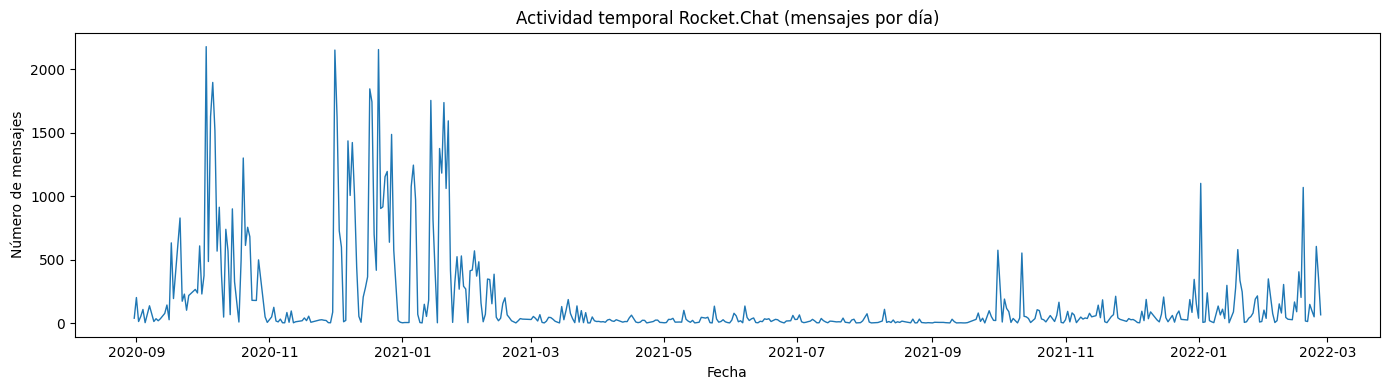

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 4))
plt.plot(
    activity_by_day["date"],
    activity_by_day["n_messages"],
    linewidth=1
)

plt.title("Actividad temporal Rocket.Chat (mensajes por día)")
plt.xlabel("Fecha")
plt.ylabel("Número de mensajes")
plt.tight_layout()
plt.show()


Ahora en Jabber:

In [53]:
from pathlib import Path
import pandas as pd
import json

jabber_root = Path("/home/drjekyll/Documentos/dark/jabb")

records = []

def iter_jabber_objects(path, chunk_size=1024*1024):
    decoder = json.JSONDecoder()
    buffer = ""
    with path.open("r", encoding="utf-8", errors="replace") as f:
        while True:
            chunk = f.read(chunk_size)
            if not chunk:
                break
            buffer += chunk
            i = 0
            n = len(buffer)
            while True:
                while i < n and buffer[i].isspace():
                    i += 1
                if i >= n:
                    break
                try:
                    obj, j = decoder.raw_decode(buffer, i)
                except json.JSONDecodeError:
                    break
                if isinstance(obj, dict):
                    yield obj
                i = j
            buffer = buffer[i:]
    buffer = buffer.strip()
    if buffer:
        try:
            obj, _ = decoder.raw_decode(buffer, 0)
            if isinstance(obj, dict):
                yield obj
        except Exception:
            pass

for path in jabber_root.glob("*.json"):
    for rec in iter_jabber_objects(path):
        ts = rec.get("ts")
        if isinstance(ts, str):
            try:
                dt = pd.to_datetime(ts, utc=True).normalize()
                records.append({"date": dt})
            except Exception:
                pass

df_jabber_dates = pd.DataFrame(records)

df_jabber_dates.head(), len(df_jabber_dates)


(                       date
 0 2020-10-07 00:00:00+00:00
 1 2020-10-07 00:00:00+00:00
 2 2020-10-07 00:00:00+00:00
 3 2020-10-07 00:00:00+00:00
 4 2020-10-07 00:00:00+00:00,
 168716)

In [54]:
# agregación diaria
jabber_activity = (
    df_jabber_dates
    .groupby("date")
    .size()
    .reset_index(name="n_messages")
    .sort_values("date")
)

jabber_activity.head(), jabber_activity.tail()


(                       date  n_messages
 0 2020-06-21 00:00:00+00:00          45
 1 2020-06-22 00:00:00+00:00        1686
 2 2020-06-23 00:00:00+00:00         715
 3 2020-06-24 00:00:00+00:00         915
 4 2020-06-25 00:00:00+00:00        1561,
                          date  n_messages
 538 2022-02-24 00:00:00+00:00          28
 539 2022-02-25 00:00:00+00:00          33
 540 2022-02-26 00:00:00+00:00          11
 541 2022-02-27 00:00:00+00:00          67
 542 2022-02-28 00:00:00+00:00          14)

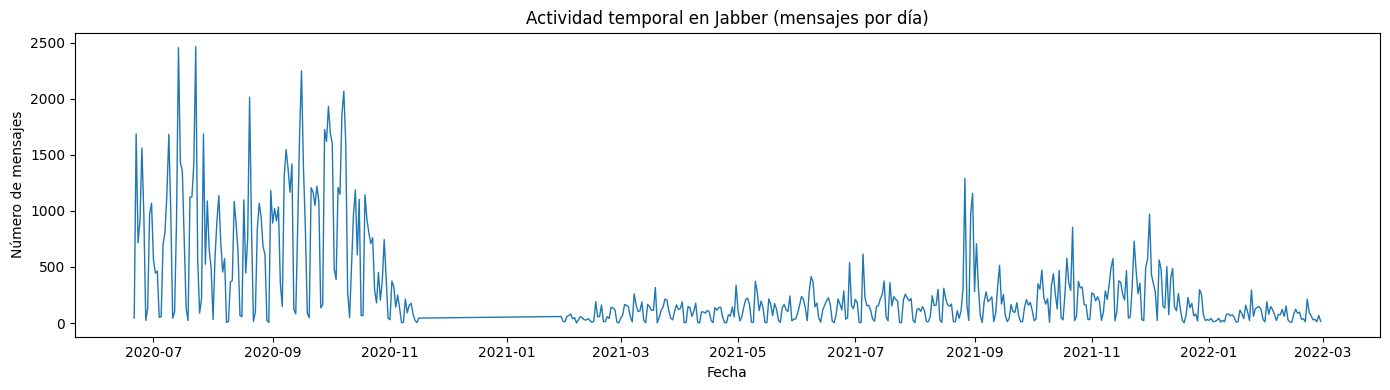

In [55]:
# Visualización temporal
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 4))
plt.plot(
    jabber_activity["date"],
    jabber_activity["n_messages"],
    linewidth=1
)

plt.title("Actividad temporal en Jabber (mensajes por día)")
plt.xlabel("Fecha")
plt.ylabel("Número de mensajes")
plt.tight_layout()
plt.show()


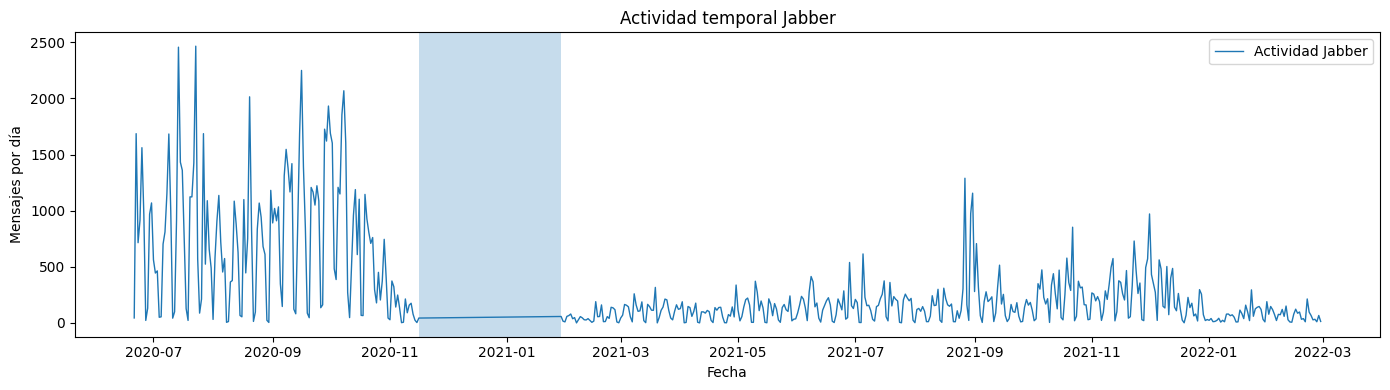

In [59]:
# lo mismo que antes pero coloreo el gap para ser más visual
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(14, 4))

plt.plot(
    jabber_activity["date"],
    jabber_activity["n_messages"],
    linewidth=1,
    label="Actividad Jabber"
)

# ZOOM!!!!!!
gap_start = pd.to_datetime("2020-11-16", utc=True)
gap_end   = pd.to_datetime("2021-01-29", utc=True)

plt.axvspan(gap_start, gap_end, alpha=0.25)

plt.title("Actividad temporal Jabber")
plt.xlabel("Fecha")
plt.ylabel("Mensajes por día")
plt.legend()
plt.tight_layout()
plt.show()


Y ahora todo junto!!!!

In [65]:
from pathlib import Path
import json
import pandas as pd

rocket_root = (
    Path.home()
    / "Documentos"
    / "dark"
    / "conti-leaks-englished"
    / "rocket-chat"
    / "original"
)

records = []

for room_dir in rocket_root.iterdir():
    if not room_dir.is_dir():
        continue

    for json_file in room_dir.glob("*.json"):
        if json_file.name in {"rooms.json", "users.list"}:
            continue

        try:
            with json_file.open("r", encoding="utf-8", errors="replace") as f:
                payload = json.load(f)
        except Exception:
            continue

        messages = payload.get("messages")
        if not isinstance(messages, list):
            continue

        for msg in messages:
            ts = msg.get("ts")
            if isinstance(ts, str):
                try:
                    dt = pd.to_datetime(ts, utc=True).normalize()
                    records.append({"date": dt})
                except Exception:
                    pass

rocket_dates = pd.DataFrame(records)

rocket_activity = (
    rocket_dates
    .groupby("date")
    .size()
    .reset_index(name="n_messages")
    .sort_values("date")
)

rocket_activity.head(), rocket_activity.tail()


(                       date  n_messages
 0 2020-08-31 00:00:00+00:00          38
 1 2020-09-01 00:00:00+00:00         201
 2 2020-09-02 00:00:00+00:00          12
 3 2020-09-03 00:00:00+00:00          52
 4 2020-09-04 00:00:00+00:00         107,
                          date  n_messages
 477 2022-02-22 00:00:00+00:00          96
 478 2022-02-23 00:00:00+00:00          49
 479 2022-02-24 00:00:00+00:00         604
 480 2022-02-25 00:00:00+00:00         358
 481 2022-02-26 00:00:00+00:00          65)

In [68]:
import pandas as pd
# rango comun alineado
start_date = min(
    rocket_activity["date"].min(),
    jabber_activity["date"].min(),
)

end_date = max(
    rocket_activity["date"].max(),
    jabber_activity["date"].max(),
)

start_date, end_date


(Timestamp('2020-06-21 00:00:00+0000', tz='UTC'),
 Timestamp('2022-02-28 00:00:00+0000', tz='UTC'))

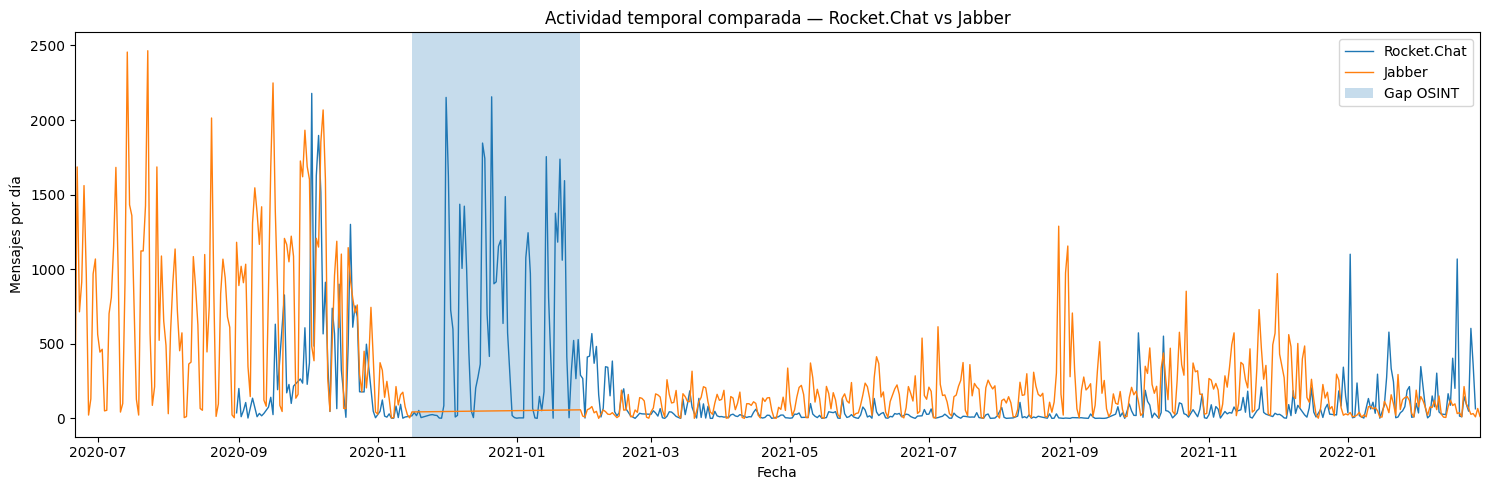

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# Rocket.Chat
plt.plot(
    rocket_activity["date"],
    rocket_activity["n_messages"],
    label="Rocket.Chat",
    linewidth=1,
)

# Jabber
plt.plot(
    jabber_activity["date"],
    jabber_activity["n_messages"],
    label="Jabber",
    linewidth=1,
)

# Gap conocido
gap_start = pd.to_datetime("2020-11-16", utc=True)
gap_end   = pd.to_datetime("2021-01-29", utc=True)

plt.axvspan(gap_start, gap_end, alpha=0.25, label="Gap OSINT")

plt.xlim(start_date, end_date)

plt.title("Actividad temporal comparada — Rocket.Chat vs Jabber")
plt.xlabel("Fecha")
plt.ylabel("Mensajes por día")
plt.legend()
plt.tight_layout()
plt.show()


Al superponer Rocket.Chat y Jabber en el mismo eje temporal observamos que los periodos de inactividad no son específicos de una plataforma, sino que afectan al ecosistema de comunicación completo. Esto sugiere una decisión operativa deliberada y no una simple migración de canal.

## Resumen
Hemos hecho por pasos:
- La ingesta y normalización de conversaciones internas procedentes de:
  - Rocket.Chat (rooms internas)
  - Jabber (mensajería punto a punto)
- La construcción de corpus actor-céntricos separados y combinados.
- El análisis exploratorio de actividad:
  - volumen de mensajes por actor,
  - evolución temporal por plataforma,
  - identificación y validación de gaps temporales mediante OSINT.

Con estos pasos se completa la fase de **Data Understanding** y **Data Preparation**.
El siguiente paso del pipeline es el **modelado lingüístico**, utilizando el corpus combinado
para analizar proximidad discursiva entre actores mediante embeddings.